# Local Feature Compression Using Autoencoders 

Group Members: <br>
Qiqi Zhang 2072838 <br> 
Francisco Pasian 2078684




We study a compression strategy for local descriptors using SURF (Speeded Up Robust Feature), which is a faster version of SIFT (Scale Invariant Feature Transform). In order to address this task, we implemented a Variational Autoencoder (VAE) model and the generated descriptor were trained with the images of dataset of Portello and Castle from https://github.com/openMVG/SfM_quality_evaluation/tree/master/Benchmarking_Camera_Calibration_2008. The testing process was done on dataset FountainP-11 and Tiso from https://drive.google.com/drive/folders/1mg54KIq6wAC8Z6ZJ2c8JH-hO28tudGu-?usp=sharing.

Once we generated the descriptors feature and a matching process, we performed a sparse reconstruction using SfM (Structure from Motion) to create a 3D visualization of the descriptors. To produce the images reconstruction we used COLMAP only for the test set.



In [1]:
# import libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# libraries for pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset, TensorDataset
import torchvision.transforms as transforms
from torch.nn import functional as F

## Load the Training dataset

(-0.5, 1023.5, 680.5, -0.5)

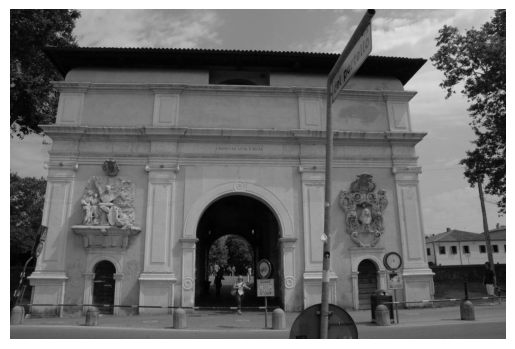

In [2]:
# one example of the training set
img_org = cv2.imread('portello/img000.jpg', 0)
img = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')

In [3]:
# Function for loading the images
def load_images(image_path):
    # List all images in the directory
    image_file = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
    # read all jpg files
    img = [cv2.imread(image_path + file, 0) for file in image_file]
    
    return image_file, img


In [5]:
# Load training dataset
train_path = 'portello/'
image_path_train, img_train = load_images(train_path)

# Load validation dataset
val_path = 'tiso/'
image_path_val, img_val = load_images(val_path)

# Load testing dataset
test_path1 = 'fountain/images/'
image_path_test1, img_test1 = load_images(test_path1)

test_path2 = 'castle30/images/'
image_path_test2, img_test2 = load_images(test_path2)



(-0.5, 3071.5, 2047.5, -0.5)

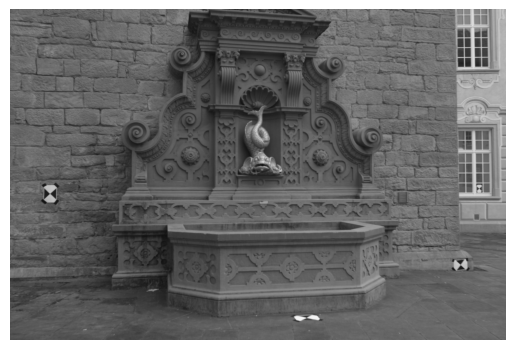

In [6]:
# one example of the test set 1
plt.imshow(cv2.cvtColor(img_test1[0],cv2.COLOR_BGR2RGB))
plt.axis('off')

In [6]:
'''print(len(img_train))
print(len(img_val))
print(len(img_test1))
print(len(img_test2))'''

'print(len(img_train))\nprint(len(img_val))\nprint(len(img_test1))\nprint(len(img_test2))'

### Data Augmentation

In [7]:
# Augmentation for training set for improving training performance

# Define torchvision transforms for augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# image paths for training set
image_paths = image_path_train  

# Directory to save augmented images
augmented_dir = 'augmented_images'
os.makedirs(augmented_dir, exist_ok=True)

augmented_image_paths = []

for idx, img_path in enumerate(image_paths):
    image = Image.open(train_path + img_path).convert("RGB")
    
    # Save original image path
    original_image_path = train_path + img_path
    
    # Apply augmentation
    augmented_image = transform(image)
    
    # Save augmented image
    augmented_image_path = os.path.join(augmented_dir, f"augmented_{idx}.jpg")
    augmented_image.save(augmented_image_path)
    
    # Add paths to the lists
    augmented_image_paths.append(augmented_image_path)



In [8]:
# Load images from augmented directory
augmented_path = 'augmented_images/'
image_path_augmented, img_augmented = load_images(augmented_path)

# Combine image paths
image_path_train.extend(image_path_augmented)

# Combine images
img_train.extend(img_augmented)

(-0.5, 1023.5, 680.5, -0.5)

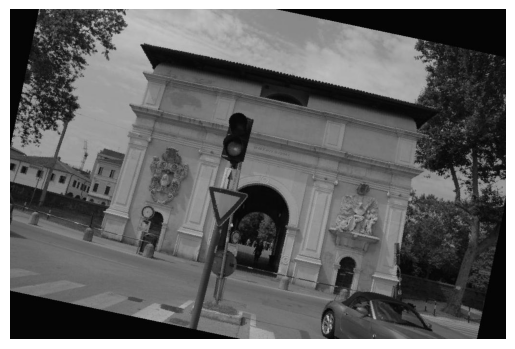

In [9]:
# one example of the augmented images for training set
plt.imshow(cv2.cvtColor(img_train[43],cv2.COLOR_BGR2RGB))
plt.axis('off')

In [10]:
'''# Verify the combined lists
print("Combined image paths:")
for path in image_path_train:
    print(path)

print(f"Total images: {len(img_train)}")'''


'# Verify the combined lists\nprint("Combined image paths:")\nfor path in image_path_train:\n    print(path)\n\nprint(f"Total images: {len(img_train)}")'

##  Extract SURF Descriptors

In [10]:
# function for extract features SURF
def extract_features_SURF(surf, images):
    # create list for keypoints and descriptors
    keypoints = []
    descriptors = []
    # run for all images
    for img in  images:
        kp, des = surf.detectAndCompute(img, None)
        # store in the list
        for i in range(len(kp)) :
            keypoints.append(kp[i])
            descriptors.append(des[i])
    return keypoints, descriptors


- Initialize SURF

We analize for different threshold values 100, 400

In [11]:
# Initialize SURF, set the threshold to be 400
surf = cv2.xfeatures2d.SURF_create(400)

# Extended version of surf to 128d
surf.setExtended(True)

In [12]:
# Extract the descriptors for the training set
kp_train, des_train = extract_features_SURF(surf, img_train)

# Extract the descriptors for the validation set
kp_val, des_val = extract_features_SURF(surf, img_val)

# Extract the descriptors for the testing set 1
kp_test1, des_test1 = extract_features_SURF(surf, img_test1)

# Extract the descriptors for the testing set 2
kp_test2, des_test2 = extract_features_SURF(surf, img_test2)


- Example 1

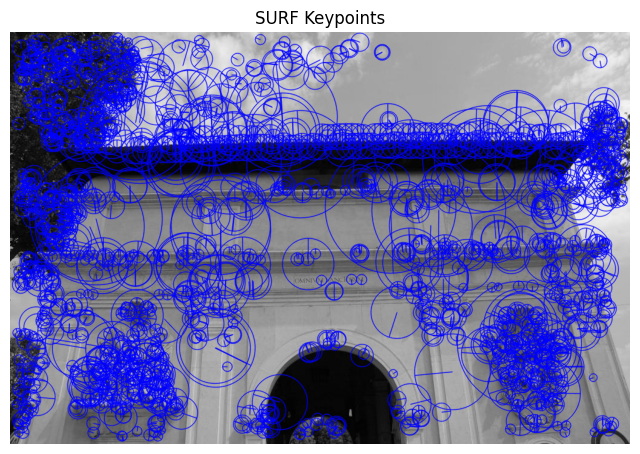

In [12]:
# Draw keypoints on the example image from training set
kp_train_1, des_train_1 = surf.detectAndCompute(img_train[0], None)
img_keypoints = cv2.drawKeypoints(img_train[0], kp_train_1, None, (255, 0, 0), 4)

# Display the image with keypoints using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
plt.title('SURF Keypoints')
plt.axis('off')
plt.show()

- Example 2

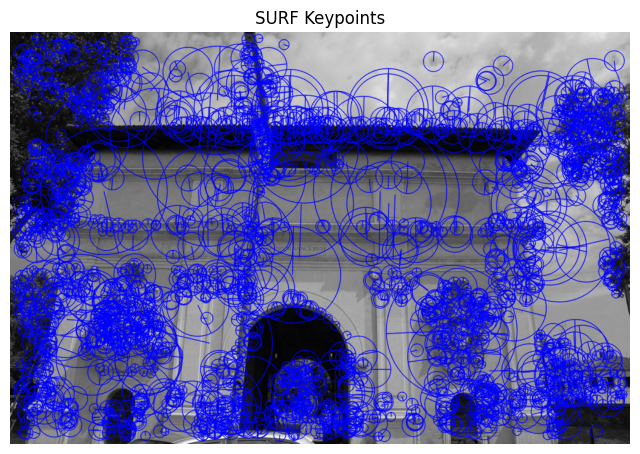

In [13]:
# Draw keypoints on the example image from training set
kp_train_2, des_train_2 = surf.detectAndCompute(img_train[1], None)
img_keypoints_2 = cv2.drawKeypoints(img_train[1], kp_train_2, None, (255, 0, 0), 4)

# Display the image with keypoints using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_keypoints_2, cv2.COLOR_BGR2RGB))
plt.title('SURF Keypoints')
plt.axis('off')
plt.show()

## Feature Matching

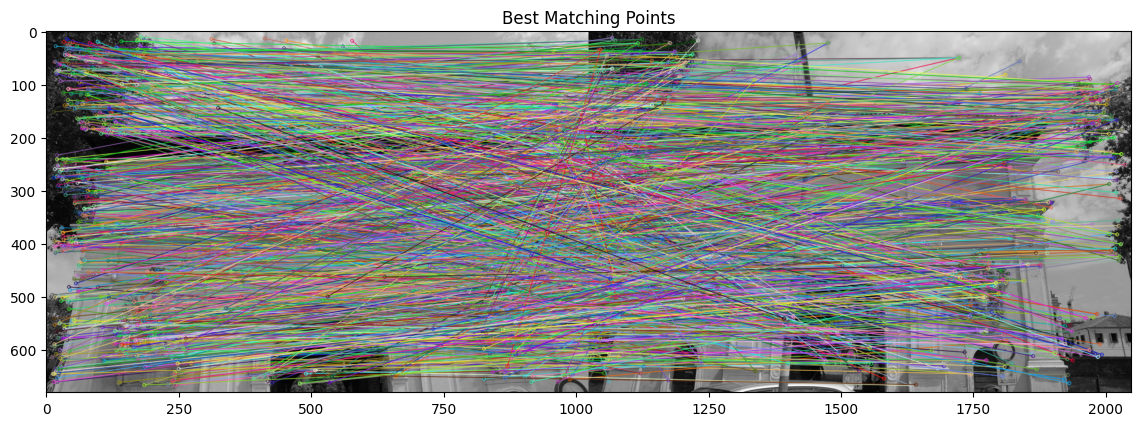

In [14]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SURF descriptors of the training image and the test image
matches = bf.match(des_train_1, des_train_2)

# Matches with shorter distance
#matches = sorted(matches, key = lambda x: x.distance)

# Select random matches to visualize in the plot
#matched_des = np.random.choice(matches, 30, replace=False).tolist()

# Order matches
ordered_matches = sorted(matches, key = lambda m:m.distance)
# Discard matches above the threshold
thrs = 700
matches = [ordered_matches[idx] for idx in range(len(ordered_matches)) if ordered_matches[idx].distance <= thrs]


result = cv2.drawMatches(img_train[0], kp_train_1, img_train[1], kp_train_2, matches, img_train[1], flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
#print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

## Train an Autoencoder

### VAE

In [13]:
# Check if  GPU is available and set it to be device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Training device: {device}")

Training device: mps


In [14]:
# Load dataset 
# function for transform numpy type to tensor
class Data2Tensor(Dataset):

  def __init__(self, data_set, transform=None):
    self.transform = transform
    self.data = data_set
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample
  
# Initilization
batch_size = 300

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        return torch.tensor(sample)

# Transform to tensor
train_transform = transforms.Compose([ToTensor()])

In [15]:
# Training set
train_set = Data2Tensor(des_train, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Validation set
val_set = Data2Tensor(des_val, transform=train_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Testing set1
test_set1 = Data2Tensor(des_test1, transform=train_transform)
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=True)

# Testing set2
test_set2 = Data2Tensor(des_test2, transform=train_transform)
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=True)

In [16]:
# class for VAE structure
class VAE(nn.Module):
    """
    VARIATIONAL AUTO-ENCODER

    Structure:
        Encoding: Imp Layer -> Hidden Layer -> Latent Layer ->  Final Layer (mu)       
                                                                Final Layer (logvar)

        Gaussian Reparametrization: Mu       ->  Z
                                    Logvar
    
        Decoding: Z -> Final Layer -> Latent Layer -> Hidden Layer -> Imp Layer (Sigmoid)

    """

    def __init__(self, input_dim=128, hidden_dim=100, latent_dim=40, final_dim = 20, relu_factor = 0.2, device = device):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(relu_factor)
            )
        
        # Mean and Logvar
        self.mean_layer = nn.Linear(latent_dim, final_dim)
        self.logvar_layer = nn.Linear(latent_dim, final_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(final_dim, latent_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        """
        Encode image 
        """
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization_gaussian(self, mean, var):
        """
        Perform reparametrization trick using a gaussian function
        """
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        """
        Decode image 
        """
        return self.decoder(x)

    def forward(self, x):
        """
        Perform forward propagation of image
        """
        mean, logvar = self.encode(x)
        z = self.reparameterization_gaussian(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar   

In [17]:
# function for computiing loss
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = F.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


### Training Model


In [18]:
# Random seed for reproducing
torch.manual_seed(123)

######## INITIAL PARAMETERS LOADING

# AUTO-ENCODER PARAMETERS
INP_DIM = 128
HID_DIM = 100
LAT_DIM = 80
FIN_DIM = 60 
RELU_T = 0.2

# TRAINING PARAMETERS
model_SURF = VAE(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM, RELU_T).to(device)
optimizer = torch.optim.Adam(model_SURF.parameters(), lr=1e-3)
epochs = 50


In [19]:
def train_model(model, train_dataloader, val_dataloader, epochs, optimizer):
    """
    Train a Variational Auto-Encoder from scratch using PyTorch

    Args: 
        model -> VAE model -> class
        dataset -> training set to be used -> tensor
        epochs -> number of epochs for training -> int
        batch_size -> batch sizes of training dataset -> int
        optimizer -> model optimizer 
        input_dim -> flatten dimension to the desire value -> int
        verbose -> show loss at each epoch -> [0,1]
    
    Return:
        overall_loss -> loss 
        model -> trained model

    """

    # Initialize model 
    model.train()
    print("Starting model training...")

    total_train_loss = []
    total_val_loss = []

    # Start iteration 
    for epoch in range(epochs):
        
        # Training phase
        model.train()
        epoch_train_loss = 0.0

        # Start iteration in batches
        for x_batch in train_dataloader:
 
            # Run model 
            x_batch = x_batch.to(device)
            optimizer.zero_grad() 
            x_hat, mean, log_var = model(x_batch)  # Generate images alongside with parameters from reparametrization trick
            loss = loss_function(x_batch, x_hat, mean,log_var) # Compute loss
            
            # Backpropagate model 
            # Set gradients to zero for avoiding gradient propagation
            loss.backward()
            optimizer.step()
            # Extraxt loss and sum
            epoch_train_loss += loss.item()
            
        # Calculate average epoch training loss
        epoch_train_loss /= len(train_dataloader.dataset)
        total_train_loss.append(epoch_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for x_batch in val_dataloader:
                x_batch = x_batch.to(device)
                x_hat, mean, log_var = model(x_batch)
                loss = loss_function(x_batch, x_hat, mean, log_var)
                epoch_val_loss += loss.item()
        
        # Calculate average epoch validation loss
        epoch_val_loss /= len(val_dataloader.dataset)
        total_val_loss.append(epoch_val_loss)
        
        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    print("Model training successfully")
        
    return total_train_loss, total_val_loss, model

### Hyperparameter Test

In [37]:
# Testing the performance if I change the value of final dim

# Define the FIN_DIM values to test
fin_dim_values = [20, 40, 60]

# Define function to train the model with different final dim values
def run_experiment(fin_dim_values, inp_dim=128, hid_dim=100, lat_dim=80, relu_t=0.2, epochs=30):
    results = {}

    for fin_dim in fin_dim_values:
        # Initialize model with the current FIN_DIM value
        model_SURF = VAE(inp_dim, hid_dim, lat_dim, fin_dim, relu_t).to(device)
        optimizer = torch.optim.Adam(model_SURF.parameters(), lr=1e-3)

        # Train the model and store the results
        loss_train, loss_val, model_train = train_model(model_SURF, train_loader, val_loader, epochs, optimizer)
        results[fin_dim] = (loss_train, loss_val)

    return results

In [38]:
# Run the experiment
results = run_experiment(fin_dim_values)

Starting model training...
Epoch [1/30], Train Loss: 1.5701, Val Loss: 0.5409
Epoch [2/30], Train Loss: 0.4616, Val Loss: 0.5384
Epoch [3/30], Train Loss: 0.4034, Val Loss: 0.3965
Epoch [4/30], Train Loss: 0.3149, Val Loss: 0.3803
Epoch [5/30], Train Loss: 0.2945, Val Loss: 0.3554
Epoch [6/30], Train Loss: 0.2644, Val Loss: 0.3180
Epoch [7/30], Train Loss: 0.2326, Val Loss: 0.2801
Epoch [8/30], Train Loss: 0.2209, Val Loss: 0.2668
Epoch [9/30], Train Loss: 0.2103, Val Loss: 0.2498
Epoch [10/30], Train Loss: 0.2025, Val Loss: 0.2442
Epoch [11/30], Train Loss: 0.1996, Val Loss: 0.2398
Epoch [12/30], Train Loss: 0.1919, Val Loss: 0.2276
Epoch [13/30], Train Loss: 0.1850, Val Loss: 0.2226
Epoch [14/30], Train Loss: 0.1784, Val Loss: 0.2117
Epoch [15/30], Train Loss: 0.1685, Val Loss: 0.2020
Epoch [16/30], Train Loss: 0.1641, Val Loss: 0.1994
Epoch [17/30], Train Loss: 0.1583, Val Loss: 0.1906
Epoch [18/30], Train Loss: 0.1541, Val Loss: 0.1879
Epoch [19/30], Train Loss: 0.1525, Val Loss: 0

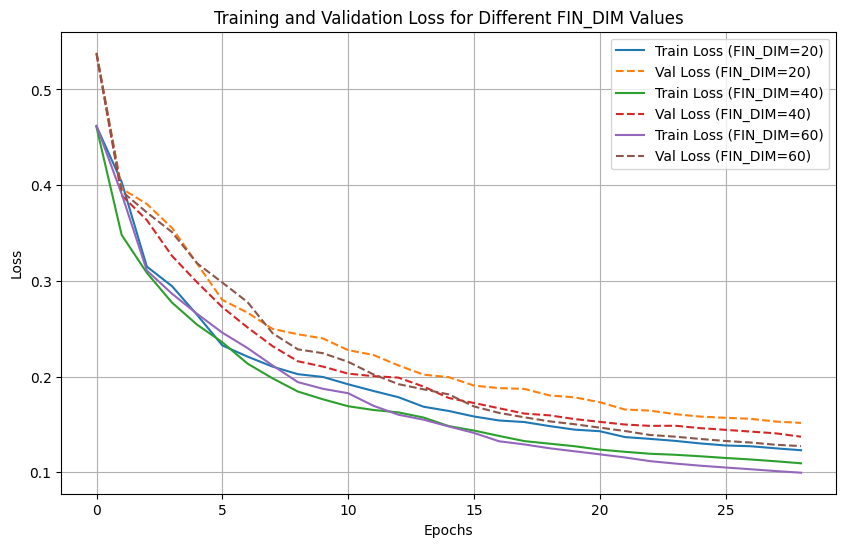

In [40]:
# Plot the results
plt.figure(figsize=(10, 6))

for fin_dim, c in zip(fin_dim_values,['b','r','g']):
    loss_train, loss_val = results[fin_dim]
    loss_train = loss_train[1:]
    loss_val = loss_val[1:]
    plt.plot(loss_train, label=f'Train Loss (FIN_DIM={fin_dim})', color=c)
    plt.plot(loss_val, label=f'Val Loss (FIN_DIM={fin_dim})', linestyle='--', color=c)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different FIN_DIM Values')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Training with best parameters
FIN_DIM = 60
model_SURF = VAE(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM, RELU_T).to(device)
optimizer = torch.optim.Adam(model_SURF.parameters(), lr=1e-3)
epochs = 50

# Run model for dataset
loss_train, loss_val, model_train = train_model(model_SURF, train_loader, val_loader, epochs, optimizer)

Starting model training...
Epoch [1/50], Train Loss: 1.4556, Val Loss: 0.4207
Epoch [2/50], Train Loss: 0.4615, Val Loss: 0.4154
Epoch [3/50], Train Loss: 0.3511, Val Loss: 0.2968
Epoch [4/50], Train Loss: 0.3045, Val Loss: 0.2689
Epoch [5/50], Train Loss: 0.2733, Val Loss: 0.2399
Epoch [6/50], Train Loss: 0.2443, Val Loss: 0.2176
Epoch [7/50], Train Loss: 0.2230, Val Loss: 0.2038
Epoch [8/50], Train Loss: 0.2057, Val Loss: 0.1811
Epoch [9/50], Train Loss: 0.1912, Val Loss: 0.1747
Epoch [10/50], Train Loss: 0.1841, Val Loss: 0.1683
Epoch [11/50], Train Loss: 0.1766, Val Loss: 0.1637
Epoch [12/50], Train Loss: 0.1699, Val Loss: 0.1565
Epoch [13/50], Train Loss: 0.1643, Val Loss: 0.1554
Epoch [14/50], Train Loss: 0.1578, Val Loss: 0.1443
Epoch [15/50], Train Loss: 0.1441, Val Loss: 0.1339
Epoch [16/50], Train Loss: 0.1390, Val Loss: 0.1318
Epoch [17/50], Train Loss: 0.1348, Val Loss: 0.1254
Epoch [18/50], Train Loss: 0.1307, Val Loss: 0.1244
Epoch [19/50], Train Loss: 0.1279, Val Loss: 0

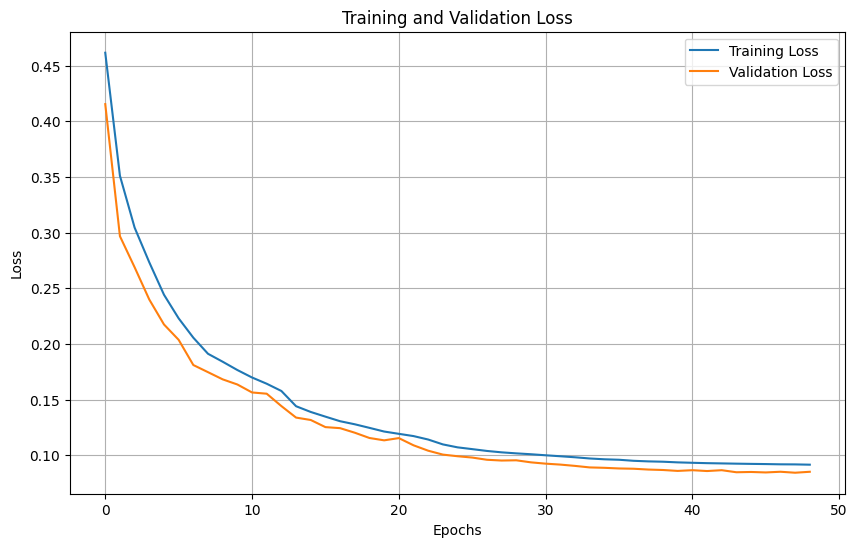

In [21]:
# plotting for training and valaìidation loss

# Eliminate the first data point
loss_train = loss_train[1:]
loss_val = loss_val[1:]

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Testing Evaluation

In [22]:
# function for calculating testing loss
def calculate_test_loss(model, test_dataloader):
    """
    Calculate the loss for the test dataset.

    Args: 
        model -> Trained VAE model -> nn.Module
        test_loader -> DataLoader for the test dataset -> DataLoader
    
    Return:
        test_loss -> Average loss over the test dataset
    """
    
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for x_batch in test_dataloader:
            x_batch = x_batch.to(device)
            x_hat, mean, log_var = model(x_batch)
            loss = loss_function(x_batch, x_hat, mean, log_var)
            test_loss += loss.item()

    # Calculate average test loss
    test_loss /= len(test_dataloader.dataset)

    return test_loss

In [23]:
# Calculate the test loss
test_loss_fountain = calculate_test_loss(model_train, test_loader1)

print(f"Test Loss for Fountain dataset: {test_loss_fountain:.4f}")

Test Loss for Fountain dataset: 0.1258


In [24]:
# Calculate the test loss
test_loss_tiso = calculate_test_loss(model_train, test_loader2)

print(f"Test Loss for tiso dataset: {test_loss_tiso:.4f}")

Test Loss for tiso dataset: 0.1210


### Reconstruction Descriptors

In [25]:
# function for descriptors reconstruction
def reconstruct_descriptors(model, x_batch):
    
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        x_batch = x_batch.to(device)
            
        # Forward pass through the VAE
        x_hat, mean, log_var = model(x_batch)
            
        # Store original and reconstructed descriptors
        reconstructions = x_hat.cpu().numpy()

    return reconstructions

In [26]:
# Reconstruct descriptors example
reconstructions_example = reconstruct_descriptors(model_train, torch.tensor(des_test1[0]))

## 3D Reconstruction by COLMAP

In [27]:
# set the ratio bound for descriptors match to get good matches
def get_good_matches(match, ratio) :

    good_match = []
    # if m/n < ratio accept the match
    for m,n in match:
        if m.distance < ratio * n.distance:
            good_match.append(m)

    return good_match

# set matcher FLANN based
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

# function for calculating matches of descriptors
def calculate_matches(des1, des2, matcher, ratio) :
    # Matches of all the descriptors
    matches_org = matcher.knnMatch(des1, des2, 2)
    matches_org_good = get_good_matches(matches_org, ratio) 

    # Reconstructe compressed descriptors
    des1_recon = reconstruct_descriptors(model_train, torch.tensor(des1))
    des2_recon = reconstruct_descriptors(model_train, torch.tensor(des2))

    # Matches of the reconstructed descriptors
    matches_recon = matcher.knnMatch(des1_recon, des2_recon, 2)
    matches_recon_good = get_good_matches(matches_recon, ratio)

    return matches_org_good, matches_recon_good


In [28]:
# function for writing the keypoints information to colmap format
def kp2colmap(path, img_name, keypoints, zeros, length):
    
    text = ''
    text += str(len(keypoints)) + length

    for key_point in keypoints:
        pos = str(key_point.pt[0]) + ' ' + str(key_point.pt[1]) + ' '
        info = pos + str(key_point.size) + ' ' + str(key_point.angle)
        text += info + ' ' + zeros + '\n'

    file_des = open(path + img_name + '.txt',"w+")
    file_des.write(text)
    file_des.close()

# function for writing the matches between 2 images
def write_matches(name1, name2, matches):
    text = name1 + ' ' + name2 + '\n'
    for match in matches :
        text += str(match.queryIdx) + ' ' + str(match.trainIdx) + '\n'
    return text


# function for writing the matches files to colmap format 
def matches2colmap(path, names, matches, idx_matches):
    # idx_matches: 0 - org, 1 - recon
    text = ''
    counter = 0 
    for idx in range(len(names)) :
        for idy in range(idx + 1, len(names)) :
            text += write_matches(names[idx], names[idy], matches[counter][idx_matches])
            counter += 1
            text += '\n'

    file_des = open(path,"w+")
    file_des.write(text)
    file_des.close()


In [29]:
# initilize functions
length = '128\n'
zeros = ''
for idx in range(128) :
    zeros += '0 ' 

### Colmap file for Fountain dataset

In [30]:
# Calculating the matches for original des and reconstructed des
kp_des = [surf.detectAndCompute(img, None) for img in img_test1]
matches_test = []
for idx in range(len(img_test1)) :
    for idy in range(idx + 1, len(img_test1)) :
        m_or, m_rec = calculate_matches(kp_des[idx][1] , kp_des[idy][1], matcher, 0.7)
        matches_test.append((m_or, m_rec))

In [31]:
# Original descriptors
path_or = 'test/fountain/kp/'
for idx in range(len(image_path_test1)) :
    kp2colmap(path_or, image_path_test1[idx], kp_des[idx][0], zeros, length)

# matching information of the images for COLMAP
path_or = 'test/fountain/matches_org.txt'
matches2colmap(path_or, image_path_test1, matches_test, 0)

In [32]:
# Reconstructed descriptors
path_rec = 'test/fountain/kp_recon/'
for idx in range(len(image_path_test1)) :
    kp2colmap(path_rec, image_path_test1[idx], kp_des[idx][0], zeros, length)

path_rec = 'test/fountain/matches_recon.txt'
matches2colmap(path_rec, image_path_test1, matches_test, 1)

### Colmap file for Castle dataset

In [33]:
# Calculating the matches for original des and reconstructed des
kp_des2 = [surf.detectAndCompute(img, None) for img in img_test2]
matches_test2 = []
for idx in range(len(img_test2)) :
    # Matching of the original features 
    for idy in range(idx + 1, len(img_test2)) :
        m_or, m_rec = calculate_matches(kp_des2[idx][1] , kp_des2[idy][1], matcher, 0.7)
        matches_test2.append((m_or, m_rec))

In [34]:
# Original descriptors
path_or = 'test/castle/kp/'
for idx in range(len(image_path_test2)) :
    kp2colmap(path_or, image_path_test2[idx], kp_des2[idx][0], zeros, length)

# matching information of the images for COLMAP
path_or = 'test/castle/matches_org.txt'
matches2colmap(path_or, image_path_test2, matches_test2, 0)

In [35]:
# Reconstructed descriptors
path_rec = 'test/castle/kp_recon/'
for idx in range(len(image_path_test2)) :
    kp2colmap(path_rec, image_path_test2[idx], kp_des2[idx][0], zeros, length)

path_rec = 'test/castle/matches_recon.txt'
matches2colmap(path_rec, image_path_test2, matches_test2, 1)

## COLMAP

We import our features and matches to see the reconstructed image for the dataset of Fountain and Tiso, for the original and recontructed results.

- First step is creating a database were we would store the images, its descriptors and the matches. We select the path to place the database (must be located in the same folder where are the .txt files)

<img src="colmap_step1.png" alt="colmap_step1" width="500"/>

- Here we import the features from our .txt files, set the camera and apply to all images.

<img src="colmap_step2.png" alt="colmap_step2" width="500"/>

- Then we import the matches, no changes from default configuration.

<img src="colmap_step3.png" alt="colmap_step3" width="500"/>

- Finally, we reconstruct the image and save the result.

### Results

- Here we can see the results from the Foutain dataset, on the left side the original reconstruction with 4341 points and on the right, the reconstructed (descriptors from the VAE model) with 3488 points.

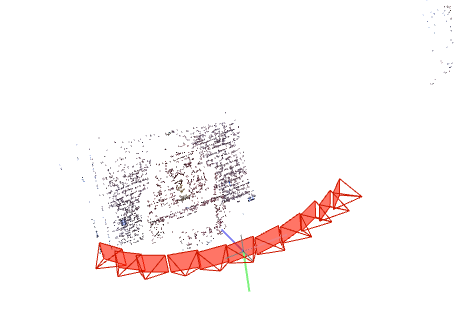 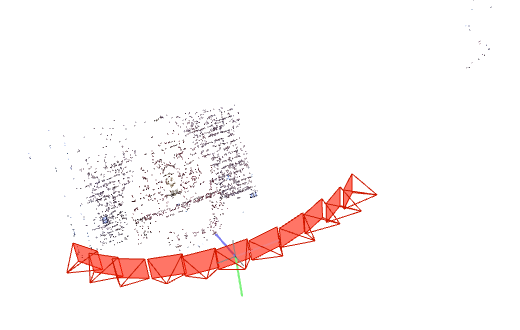

- Here we can see the results from the Castle dataset, on the left side the original reconstruction with 12190 points and on the right, the reconstructed (descriptors from the VAE model) with 11268 points.

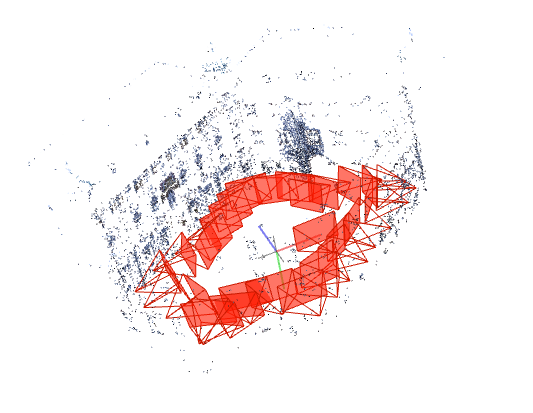 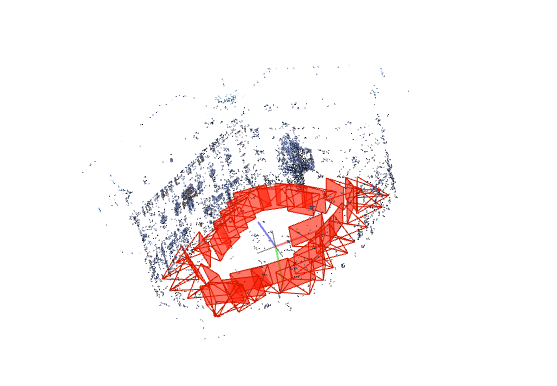

# References

- Surf implementation https://github.com/deepanshut041/feature-detection/blob/master/surf/surf.ipynb and https://docs.opencv.org/4.x/df/dd2/tutorial_py_surf_intro.html
- Labs from Vision & Cognitive Systems
- COLMAP: https://colmap.github.io/tutorial.html